# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных


Данные находятся в трёх файлах:
- `gold_recovery_train.csv` — обучающая выборка Скачать датасет;
- `gold_recovery_test.csv` — тестовая выборка Скачать датасет;
- `gold_recovery_full.csv` — исходные данные Скачать датасет.

Данные индексируются датой и временем получения информации (признак date). 

##### Технологический процесс
- `Rougher feed` — исходное сырье
- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - `Xanthate` — ксантогенат (промотер, или активатор флотации);
    - `Sulphate` — сульфат (на данном производстве сульфид натрия);
    - `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

###### Параметры этапов
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

###### Наименование признаков
Наименование признаков должно быть такое:
<b>[этап].[тип_параметра].[название_параметра]</b>.
Пример: `rougher.input.feed_ag`

Возможные значения для блока <b>[этап]</b>:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

Возможные значения для блока <b>[тип_параметра]</b>:
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

 # Содержание


### [1 Подготовка данных](#1-bullet)
#### [1.1 Открытие и изучение данных](#1.1-bullet)
#### [1.2 Проверка правильности расчета эффективности обогащения. Вычисление MAE](#1.2-bullet)
#### [1.3 Анализ признаков, недоступных в тестовой выборке](#1.3-bullet)
#### [1.4 Предобработка данных](#1.4-bullet)
### [2 Анализ данных](#2-bullet)
#### [2.1 Исследование концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#2.1-bullet)
#### [2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#2.2-bullet)
#### [2.3 Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах](#2.3-bullet)

### [3 Построение модели](#3-bullet)
#### [3.1 Функция для вычисления sMAPE](#3.1-bullet)
#### [3.2 Выбор модели и обучение](#3.2-bullet)
#### [3.3 Итоговый расчет sMAPE](#3.3-bullet)

### [4 Выводы](#4-bullet)

# 1 Подготовка данных <a class="anchor" id="1-bullet"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## 1.1 Откроем файлы и изучим их. <a class="anchor" id="1.1-bullet"></a>

In [2]:
# исходные данные
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
# обучающая выборка
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
# тестовая выборка
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

In [3]:
def df_info(df):
    
    display(df.head(2))
    display(df.info())
    
    print("Размер таблицы:", df.shape)
    print("Количество дублей:", df.duplicated().sum())

In [4]:
df_info(df_full)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

None

Размер таблицы: (22716, 87)
Количество дублей: 0


- Исходные данные содержат 22716 объектов и 87 признаков.
- Есть пропуски. Дубликаты отсутствуют.
- Все данные, кроме `date` имеют тип `float64`.

In [5]:
df_info(df_train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

Размер таблицы: (16860, 87)
Количество дублей: 0


- Исходные данные содержат 16860 объектов и 87 признаков.
- Есть пропуски. Дубликаты отсутствуют.
- Все данные, кроме `date` имеют тип `float64`.

In [6]:
df_info(df_test)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

None

Размер таблицы: (5856, 53)
Количество дублей: 0


- Исходные данные содержат 5856 объектов и 53 признака.
- Есть пропуски. Дубликаты отсутствуют.
- Все данные, кроме `date` имеют тип `float64`.
- Как сказано в условии, в тестовой выборке `df_test` содержатся не все признаки, которые есть в обучающей выборке `df_train`. Также отсутствуют целевые признаки.

###### Структурируем все признаки для наглядности:

### Флотация

    Исходное сырье:
        1. rougher.input.feed_ag 
        2. rougher.input.feed_pb
        3. rougher.input.feed_au
        4. rougher.input.feed_sol
     Характеристики руды:
        5. rougher.input.feed_size
        6. rougher.input.feed_rate
     Сырье для флотационного реагента:
        7. rougher.input.floatbank11_sulfate
        8. rougher.input.floatbank11_xanthate
        9. rougher.input.floatbank10_sulfate
        10. rougher.input.floatbank10_xanthate
     Объём воздуха и уровень жидкости:
        11. rougher.state.floatbank10_a_air
        12. rougher.state.floatbank10_a_level   
        13. rougher.state.floatbank10_b_air
        14. rougher.state.floatbank10_b_level    
        15. rougher.state.floatbank10_c_air
        16. rougher.state.floatbank10_c_level   
        17. rougher.state.floatbank10_d_air
        18. rougher.state.floatbank10_d_level    
        19. rougher.state.floatbank10_e_air
        20. rougher.state.floatbank10_e_level    
        21. rougher.state.floatbank10_f_air
        22. rougher.state.floatbank10_f_level
        
#### Целевые признаки

     Расчётные характеристики:
        1. rougher.calculation.sulfate_to_au_concentrate
        2. rougher.calculation.floatbank10_sulfate_to_au_feed
        3. rougher.calculation.floatbank11_sulfate_to_au_feed
        4. rougher.calculation.au_pb_ratio
     Отвальные хвосты:
        5. rougher.output.tail_ag
        6. rougher.output.tail_pb
        7. rougher.output.tail_sol
        8. rougher.output.tail_au
     Финальный концентрат:
        9. rougher.output.concentrate_ag
        10. rougher.output.concentrate_pb
        11. rougher.output.concentrate_sol
        12. rougher.output.concentrate_au
     Коэффициент качества обогащения:
        13. rougher.output.recovery  
        
### Первичная очистка

     Характеристики руды:
        1. primary_cleaner.input.feed_size
     Сырье для реагента очистки:
        2. primary_cleaner.input.xanthate
        3. primary_cleaner.input.sulfate
        4. primary_cleaner.input.depressant
     Объём воздуха и уровень жидкости:
        5. primary_cleaner.state.floatbank8_a_air
        6. primary_cleaner.state.floatbank8_a_level    
        7. primary_cleaner.state.floatbank8_b_air
        8. primary_cleaner.state.floatbank8_b_level    
        9. primary_cleaner.state.floatbank8_c_air
        10. primary_cleaner.state.floatbank8_c_level   
        11. primary_cleaner.state.floatbank8_d_air
        12. primary_cleaner.state.floatbank8_d_level
#### Целевые признаки
     Отвальные хвосты:
        1. primary_cleaner.output.tail_ag
        2. primary_cleaner.output.tail_pb
        3. primary_cleaner.output.tail_sol
        4. primary_cleaner.output.tail_au
     Финальный концентрат:
        5. primary_cleaner.output.concentrate_ag
        6. primary_cleaner.output.concentrate_pb
        7. primary_cleaner.output.concentrate_sol
        8. primary_cleaner.output.concentrate_au    
        
### Вторичная очистка

#### Объём воздуха и уровень жидкости:
        1. secondary_cleaner.state.floatbank2_a_air
        2. secondary_cleaner.state.floatbank2_a_level
        3. secondary_cleaner.state.floatbank2_b_air
        4. secondary_cleaner.state.floatbank2_b_level
        5. secondary_cleaner.state.floatbank3_a_air
        6. secondary_cleaner.state.floatbank3_a_level
        7. secondary_cleaner.state.floatbank3_b_air
        8. secondary_cleaner.state.floatbank3_b_level
        9. secondary_cleaner.state.floatbank4_a_air
        10. secondary_cleaner.state.floatbank4_a_level
        11. secondary_cleaner.state.floatbank4_b_air
        12. secondary_cleaner.state.floatbank4_b_level
        13. secondary_cleaner.state.floatbank5_a_air
        14. secondary_cleaner.state.floatbank5_a_level
        15. secondary_cleaner.state.floatbank5_b_air
        16. secondary_cleaner.state.floatbank5_b_level
        17. secondary_cleaner.state.floatbank6_a_air
        18. secondary_cleaner.state.floatbank6_a_level
#### Целевые признаки
     Отвальные хвосты:
        1. secondary_cleaner.output.tail_ag
        2. secondary_cleaner.output.tail_pb
        3. secondary_cleaner.output.tail_sol
        4. secondary_cleaner.output.tail_au
        
### Финальные характеристики

#### Целевые признаки
     Отвальные хвосты:
        1. final.output.tail_ag
        2. final.output.tail_pb
        3. final.output.tail_sol
        4. final.output.tail_au
     Финальный концентрат:
        5. final.output.concentrate_ag
        6. final.output.concentrate_pb
        7. final.output.concentrate_sol
        8. final.output.concentrate_au
     Коэффициент качества обогащения:
        9. final.output.recovery

## 1.2 Проверка правильности расчета эффективности обогащения. Вычисление MAE <a class="anchor" id="1.2-bullet"></a>

 Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`. Найдите `MAE` между расчётами и значением признака.

In [7]:
# Для того, чтобы быть уверенным, что данные наших фреймов независимы, 
# лучше воспользоваться DataFrame.copy(deep=True) (deep=True - по умолчанию).

temp = df_train.copy(deep=True) #делаем копию обучающей выборки.
temp.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

Эффективность обогащения `Recovery` рассчитывается по формуле:

#### Recovery = (C * (F - T)) / (F * (C - T)) * 100% ,

где:
- <b>C</b> — доля золота в концентрате после флотации/очистки;
- <b>F</b> — доля золота в сырье/концентрате до флотации/очистки;
- <b>T</b> — доля золота в отвальных хвостах после флотации/очистки.


In [8]:
# объявим переменные
C = temp['rougher.output.concentrate_au']
F = temp['rougher.input.feed_au']
T = temp['rougher.output.tail_au']

In [9]:
# посчитаем значение recovery и сохраним ее значениe в столбце `recovery_count`.

temp['recovery_count'] = C * (F - T) / (F * (C - T)) * 100

In [10]:
# удалим пропуски, иначе функция `mean_absolute_error` ругается на наличие в данных `NaN`.
temp.dropna(inplace = True) 

# вычисляем MAE между расчётами и значением признака
MAE = mean_absolute_error(temp['recovery_count'], temp['rougher.output.recovery'])
print('MAE между расчётами и значением признака =', MAE)

MAE между расчётами и значением признака = 9.555596961987514e-15


- Значение MAE  практически равно нулю. 
- Эффективность обогащения рассчитана правильно.

## 1.3 Анализ признаков, недоступных в тестовой выборке <a class="anchor" id="1.3-bullet"></a>

Проанализируем признаки, недоступные в тестовой выборке `df_test`. Что это за параметры? К какому типу относятся?

In [11]:
# все признаки датасета df_train
columns_train = set(df_train.columns)

#print(columns_train)

In [12]:
# все признаки датасета df_test
columns_test = set(df_test.columns)

#print(columns_test)

In [13]:
delta_columns = columns_train - columns_test

In [14]:
display('В тестовом наборе нет следующих признаков:', delta_columns)

'В тестовом наборе нет следующих признаков:'

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. 

В тестовом наборе также нет целевых признаков. Добавим их.

In [15]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')

## 1.4 Предобработка данных <a class="anchor" id="1.4-bullet"></a>

Заменим тип данных в признаке `date` во всех датасетах.

In [16]:
for df in [df_full, df_train, df_test]:
    df['date'] = pd.to_datetime(df['date'])
    print(df['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


Чтобы в дальнейшем обучать модель на одинаково структурированных данных, удалим из датасета `df_train` те признаки, которых нет в датасете `df_test`.

In [17]:
df_train = df_train[df_test.columns]

In [18]:
# выведем размеры обучающей и тестовой выборок.
print(df_test.shape, df_train.shape)

(5856, 55) (16860, 55)


Удалим строки в выборках, которые содержат пропуски в целевых признаках.

In [19]:
df_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
df_train.reset_index(drop=True, inplace=True)

df_test.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
df_test.reset_index(drop=True, inplace=True)

df_full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
df_full.reset_index(drop=True, inplace=True)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
date                                          14149 non-null datetime64[ns]
primary_cleaner.input.sulfate                 14129 non-null float64
primary_cleaner.input.depressant              14117 non-null float64
primary_cleaner.input.feed_size               14149 non-null float64
primary_cleaner.input.xanthate                14049 non-null float64
primary_cleaner.state.floatbank8_a_air        14145 non-null float64
primary_cleaner.state.floatbank8_a_level      14148 non-null float64
primary_cleaner.state.floatbank8_b_air        14145 non-null float64
primary_cleaner.state.floatbank8_b_level      14148 non-null float64
primary_cleaner.state.floatbank8_c_air        14147 non-null float64
primary_cleaner.state.floatbank8_c_level      14148 non-null float64
primary_cleaner.state.floatbank8_d_air        14146 non-null float64
primary_cleaner.state.floatbank8_d_level      14148 non-

Напишем функцию, которая будет заменять пропуски. Воспользуемся подсказкой из задания, что: 
> Данные индексируются датой и временем получения информации (признак `date`).
> <br><b>Соседние по времени параметры часто похожи.</b>

In [21]:
def fill_missing_value(df):
    df.fillna(method='ffill', inplace=True)
    display(df.info())

In [22]:
fill_missing_value(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 55 columns):
date                                          5290 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
ro

None

In [23]:
fill_missing_value(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
date                                          14149 non-null datetime64[ns]
primary_cleaner.input.sulfate                 14149 non-null float64
primary_cleaner.input.depressant              14149 non-null float64
primary_cleaner.input.feed_size               14149 non-null float64
primary_cleaner.input.xanthate                14149 non-null float64
primary_cleaner.state.floatbank8_a_air        14149 non-null float64
primary_cleaner.state.floatbank8_a_level      14149 non-null float64
primary_cleaner.state.floatbank8_b_air        14149 non-null float64
primary_cleaner.state.floatbank8_b_level      14149 non-null float64
primary_cleaner.state.floatbank8_c_air        14149 non-null float64
primary_cleaner.state.floatbank8_c_level      14149 non-null float64
primary_cleaner.state.floatbank8_d_air        14149 non-null float64
primary_cleaner.state.floatbank8_d_level      14149 non-

None

In [24]:
print(df_test.shape, df_train.shape)

(5290, 55) (14149, 55)


# 2. Анализ данных <a class="anchor" id="2-bullet"></a>

## 2.1 Исследование концентрации металлов (Au, Ag, Pb) на различных этапах очистки <a class="anchor" id="2.1-bullet"></a>

Для анализа изменения концентрации на разных этапах очистки нам потребуются следующие признаки:
- `rougher.input.feed` - перед флотацией,
- `rougher.output.concentrate` - после флотации, т.е. перед первым этапом очистки,
- `primary_cleaner.output.concentrate` - после 1 этапа очистки,
- `final.output.concentrate` - после 2 этапа очистки, или финальный выход металлов.


In [25]:
# напишем функцию, которая на вход принимает название метала, 
# на выходе формирует название признаков, относящихся к этому металу.

def concentrate(metal):
    columns_name = ['rougher.input.feed', 'rougher.output.concentrate',
               'primary_cleaner.output.concentrate','final.output.concentrate']
    for i in range(len(columns_name)):
        columns_name[i] = columns_name[i] + '_' + metal
    return columns_name

In [26]:
def plot_metal(metal):
    df_full[concentrate(metal)].plot.kde()
    plt.title('Концентрация "' + metal + '" на разных стадиях')
    plt.xlim(0,)
    plt.show()

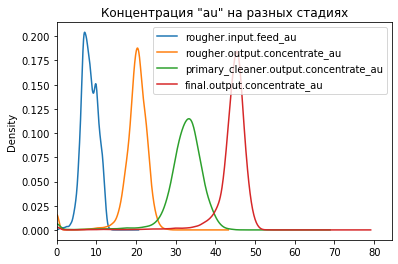

In [27]:
plot_metal('au')

- график отображает, что концентрация золота с каждым этапом увеличивается.
- итоговая концентрация золота в финальном концентрате не превышает 50%.

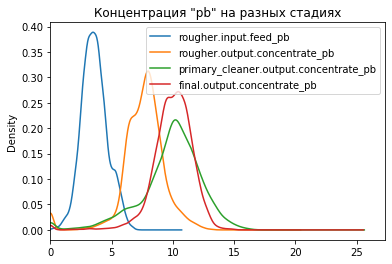

In [28]:
plot_metal('pb')

- концентрация свинца с каждым этапом также увеличивается, кроме последнего.
- предположительно второй этам (зеленая кривая) очистки никак не изменяет концентрацию свинца.

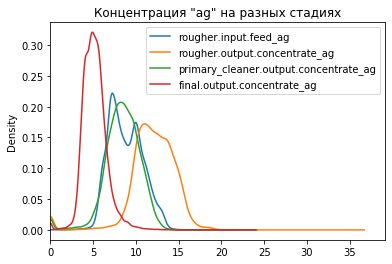

In [29]:
plot_metal('ag')

- концентрация серебра максимальная после флотации, затем после каждого этапа снижается.
- минимальная содержание серебра после финальной очистки концентрата.

## 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках <a class="anchor" id="2.2-bullet"></a>

Для анализа нам потребуются признаки:
- rougher.input.feed_size
- primary_cleaner.input.feed_size

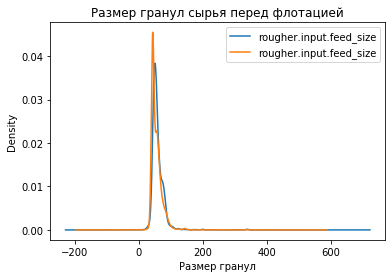

In [30]:
df_train['rougher.input.feed_size'].plot.kde()
df_test['rougher.input.feed_size'].plot.kde()
plt.title('Размер гранул сырья перед флотацией')
plt.xlabel('Размер гранул')
plt.legend()
plt.show()

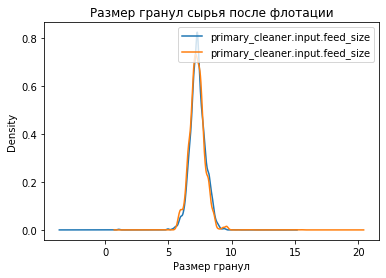

In [31]:
df_train['primary_cleaner.input.feed_size'].plot.kde()
df_test['primary_cleaner.input.feed_size'].plot.kde()
plt.title('Размер гранул сырья после флотации')
plt.xlabel('Размер гранул')
plt.legend()
plt.show()

Распределения похожи. Они оба унимодальны, их средние и дисперсии очень близки друг к другу. Можно сказать, что распределения очень близки друг к другу, поэтому оценка модели должна получиться правильной.

## 2.3 Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах <a class="anchor" id="2.3-bullet"></a>

Для анализа суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах на потребуется работать со следующими признаками:
- `rougher.input.feed`,
- `rougher.output.concentrate`,
- `primary_cleaner.output.concentrate`,
- `final.output.concentrate`.

In [32]:
df_full['input_flotation'] = df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_pb'] + df_full['rougher.input.feed_ag']
df_full['output_flotation'] = df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_pb'] + df_full['rougher.output.concentrate_ag']
df_full['output_primary_cleaner'] = df_full['primary_cleaner.output.concentrate_au'] + df_full['primary_cleaner.output.concentrate_pb']  + df_full['primary_cleaner.output.concentrate_ag']
df_full['output_final'] = df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_pb'] + df_full['final.output.concentrate_ag']    


In [33]:
name_of_columns = ['input_flotation','output_flotation','output_primary_cleaner','output_final']

In [34]:
df_full[name_of_columns].describe()

,input_flotation,output_flotation,output_primary_cleaner,output_final
count,19339.000000,19439.000000,19323.000000,19438.000000
mean,20.704124,39.373032,50.406418,59.224653
std,4.417072,6.863389,7.603610,6.093911
min,0.030000,0.000000,0.000000,0.000000
25%,17.299416,38.394639,50.077105,59.298674
50%,20.185052,40.312648,51.922084,60.307296
75%,23.817098,42.365102,53.392840,61.096690
max,33.498784,55.568687,60.269003,64.968881


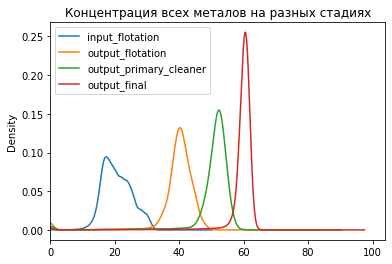

In [35]:
df_full[name_of_columns].plot.kde()
plt.title('Концентрация всех металов на разных стадиях')
plt.xlim(0,)
plt.show()

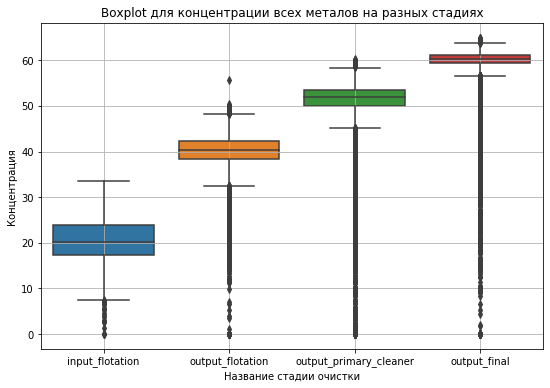

In [36]:
plt.figure(figsize=(9,6))

sns.boxplot(data = df_full[name_of_columns])
plt.title('Boxplot для концентрации всех металов на разных стадиях')
plt.ylabel('Концентрация')
plt.xlabel('Название стадии очистки')
plt.grid(True)
plt.show()

- общая концентрация всех металов с каждой стадией растет,
- в данных есть выбросы (особенно бросаются те выбросы, где концентрация равно 0). Выбросы удалим.

In [37]:
# напишем функцию для удаления выбросов
def operating_values(df, column):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    column_cleanest = df.loc[(df[column] > (q1 - 1.5*iqr)) & (df[column] < (q3 + 1.5*iqr))]
    return column_cleanest

In [38]:
df_full.shape

(19439, 91)

In [39]:
for column in name_of_columns:
    df_full = operating_values(df_full, column)

In [40]:
df_full.shape

(16595, 91)

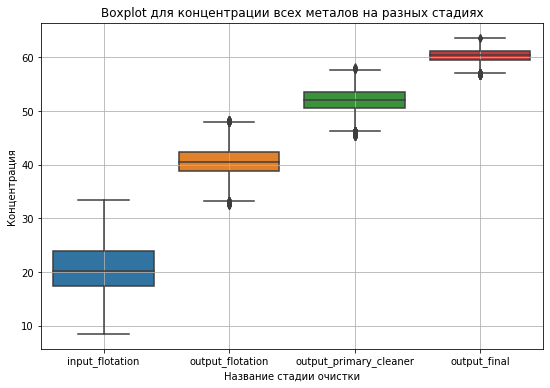

In [41]:
plt.figure(figsize=(9,6))

sns.boxplot(data = df_full[name_of_columns])
plt.title('Boxplot для концентрации всех металов на разных стадиях')
plt.ylabel('Концентрация')
plt.xlabel('Название стадии очистки')
plt.grid(True)
plt.show()

In [42]:
df_full[name_of_columns].describe()

,input_flotation,output_flotation,output_primary_cleaner,output_final
count,16595.000000,16595.000000,16595.000000,16595.000000
mean,20.790977,40.625906,51.955500,60.295928
std,4.283455,2.816340,2.197323,1.189653
min,8.440719,32.531284,45.367030,56.757304
25%,17.379278,38.778688,50.611473,59.505194
50%,20.258206,40.481409,52.110410,60.407498
75%,23.856987,42.450025,53.475727,61.140109
max,33.498784,48.307048,58.146832,63.697071


Данные хорошо отфильтровались по выбросам. Удалим теперь эти выбросы в обучающей и тестовой выборках `df_train` и `df_test`.
В качестве уникального индекса будем использовать признак `date`.

In [43]:
print(df_train.shape, df_test.shape)

(14149, 55) (5290, 55)


In [44]:
df_train = df_train.loc[df_train['date'].isin(df_full['date'])]
df_test = df_test.loc[df_test['date'].isin(df_full['date'])]

In [45]:
df_train = df_train.drop(['date'], axis = 1)
df_test = df_test.drop(['date'], axis = 1)

In [46]:
print(df_train.shape, df_test.shape)

(11996, 54) (4599, 54)


- потеряли в районе 17% и 14% в обучающей и тестовой выборках соответственно,
- в итоге имеем очищенные датасеты для обучения и теста `df_train` и `df_test`.

# 3. Построение модели <a class="anchor" id="3-bullet"></a>

## 3.1 Функция для вычисления sMAPE <a class="anchor" id="3.1-bullet"></a>

Напишем функцию для вычисления sMAPE.

In [47]:
#def smape(target, prediction):
    
#    target = np.array(target)
#    prediction = np.array(prediction)

#    smape_i = []
#    for i in range(len(target)):
#        smape_i.append(abs(target[i] - prediction[i]) / ((abs(target[i]) + abs(prediction[i])) / 2) * 100)
      
#    smape = sum(smape_i) / len(target)
#    return smape

In [48]:
def smape(target, prediction):
    smape = 2 * abs(target - prediction) / (abs(target) + abs(prediction)) * 100
    smape = smape.sum() / len(target)
    return smape

## 3.2 Выбор модели и обучение <a class="anchor" id="3.2-bullet"></a>

In [49]:
# создадим наборы данных features (признаки) и target (целевой признак).
target_train_rougher = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']
features_train = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)

target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']
features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)

Рассмотрим три модели:
- `LinearRegression`,
- `DecisionTreeRegressor`,
- `RandomForestRegressor`.

In [50]:
# создадим параметр scorer:
scorer = make_scorer(smape, greater_is_better=False)

In [52]:
model = LinearRegression()
final_score = cross_val_score(model, features_train, target_train_rougher, scoring=scorer, cv=3).mean() 
print(abs(final_score))

9.76527169906142


In [ ]:
model = DecisionTreeRegressor(random_state = 12345)    
final_score = cross_val_score(model, features_train, target_train_rougher, scoring=scorer, cv=3).mean() 
print(abs(final_score))

In [ ]:
model = RandomForestRegressor(random_state = 12345)
final_score = cross_val_score(model, features_train, target_train_rougher, scoring=scorer, cv=3).mean() 
print(abs(final_score))

Лучше других показала себя модель RandomForestRegressor. Далее работать будем с ней. Подберем наиболее удачные гиперпараметры.


In [ ]:
#for est in range(30, 100, 20):
#    for depth in range(5, 12, 2):

In [ ]:
%%time

# При использовании Jupyterhub на https://praktikum.yandex.ru/ 
# CPU times: user 1min 43s, sys: 22 ms, total: 1min 43s
# Wall time: 2min


best_result = 1000
best_depth = 0
best_n_estimators = 0

for depth in range(1,11,2): 
    for estimators in range(1,50,10):
        model = RandomForestRegressor(max_depth=depth, n_estimators=estimators, random_state=12345)
        
        final_score = cross_val_score(model, features_train, target_train_rougher, scoring=scorer, cv=3).mean()
       
        #print(final_score)
        
        if  abs(best_result) >= abs(final_score):
            best_result = final_score
            best_depth = depth
            best_n_estimators = estimators
            
print('Лучший результат =', best_result, 'при depth = ', best_depth,  'и при n_estimators = ', best_n_estimators)

In [ ]:
model = RandomForestRegressor(max_depth=best_depth, n_estimators=best_n_estimators, random_state=12345)
final_score1 = cross_val_score(model, features_train, target_train_rougher, scoring=scorer, cv=3).mean()
final_score2 = cross_val_score(model, features_train, target_train_final, scoring=scorer, cv=3).mean()

In [ ]:
smape_result = 0.25 * final_score1 + 0.75 * final_score2
abs(smape_result)

## 3.3 Итоговый расчет sMAPE <a class="anchor" id="3.3-bullet"></a>

Далее будем работать с моделью `RandomForestRegressor` и параметрами `max_depth = 105` и `n_estimators =  14`.

In [ ]:
model = RandomForestRegressor(max_depth=best_depth, n_estimators=best_n_estimators, random_state=12345)

# обучим модель на предсказание коэффициента качества обогащения "rougher.output.recovery"
model.fit(features_train, target_train_rougher)
# предскажем значения "rougher.output.recovery" для тестовой выборки
predictions_rougher = model.predict(features_test)

# обучим модель на предсказание коэффициента качества обогащения "final.output.recovery"
model.fit(features_train, target_train_final)
# предскажем значения "final.output.recovery" для тестовой выборки
predictions_final = model.predict(features_test)

In [ ]:
#Вычислим итоговое значение smape_final:
    
smape_rougher = smape(target_test_rougher, predictions_rougher)
smape_final = smape(target_test_final, predictions_final)
smape_result = 0.25 * smape_rougher + 0.75 * smape_final
print('Итоговое значение sMAPE =', round(smape_result,2))

## 4 Выводы: <a class="anchor" id="4-bullet"></a>

- Открыты и изучены исходные данные. Структурированы все признаки исходных данных.
- Проведена предобработка данных. Заполнены пропуски.
- Доказано, что эффективность обогащения рассчитана правильно. MAE между расчётами и значением признака практически равно нулю.
- Исследованы концентрации металлов (Au, Ag, Pb) на различных этапах очистки:
    - концентрация золота с каждым этапом увеличивается, итоговая концентрация золота в финальном концентрате не превышает 50%.
    - концентрация свинца с каждым этапом также увеличивается, кроме последнего. Предположительно второй этам очистки никак не изменяет концентрацию свинца.
    - концентрация серебра максимальная после флотации, затем после каждого этапа снижается.  Минимальная содержание серебра после финальной очистки концентрата.
- Проведено сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. В результате выяснили, что распределения похожи. Оба унимодальны, их средние и дисперсии очень близки друг к другу.
- Исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах и выявлено:
    - общая концентрация всех металов с каждой стадией растет.
    - в данных были выбросы. Выбросы удалены.
- Построено несколько моделей машинного обучения и выбрана RandomForestRegressor как самая лучшая.
- Написана функция для расчета sMAPE.
- На основании выбранной модели и оптимальных гиперпараметров расчитано итоговое значние sMAPE = 6.51.

